In [1]:
# This can be omitted when qedtool is a module that can be imported
import sys
sys.path.append("../../")

import transforms3d
import numpy as np
import qedtool as qtl

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cmasher as cmr

# Extra's for plotting
plt.rc('text', usetex=True);
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams.update({'font.size': 11, 'text.latex.preamble': r'\usepackage{amsfonts}'});
plt.rcParams['font.family'] = 'Bitstream Charter'

In [2]:
m = qtl.constant("electron mass")
e = qtl.constant("elementary charge")

In [3]:
p = 0.2
energy = np.sqrt(p**2 + m**2)
phi = np.linspace(0, 2*np.pi, 100)
theta = np.linspace(0, np.pi, 100)

In [4]:
pmu_e = qtl.FourVector(energy, p, 0, 0)
pmu_p = -pmu_e

plus_l = qtl.QuantumState.single(pmu_e, "L")
plus_r = qtl.QuantumState.single(pmu_e, "R")
plus_h = qtl.QuantumState.single(pmu_e, "H")
minus_r = qtl.QuantumState.single(pmu_p, "R")
minus_v = qtl.QuantumState.single(pmu_p, "V")
minus_l = qtl.QuantumState.single(pmu_p, "L")

state_1 = (plus_l * minus_r + plus_h * minus_v) / np.sqrt(2)
state_2 = plus_r * minus_r
w = [0.4, 0.6]
states = [state_1, state_2]
in_state = qtl.QuantumState.mixed(states, w)
# in_state = state_2

In [5]:
# 3-velocity of the pair
beta_cm = qtl.ThreeVector.beta(pmu_e)
print(np.sqrt(beta_cm * beta_cm))

0.3644680589773209


In [6]:
hand_ll = qtl.handedness_config(4, [2, 3], [-1, -1])
hand_lr = qtl.handedness_config(4, [2, 3], [-1, 1])
hand_rl = qtl.handedness_config(4, [2, 3], [1, -1])
hand_rr = qtl.handedness_config(4, [2, 3], [1, 1])

h = [hand_ll, hand_lr, hand_rl, hand_rr]

In [7]:
data = qtl.empty_lists(12)

In [8]:
for a in range(len(phi)):
    
    data_a = qtl.empty_lists(12)
    
    for i in range(len(theta)):

        amplitudes = []

        for j in range(len(h)):

            amplitudes_row = []

            for k in range(len(h[j])):

                # k-loop

                kmu_1 = qtl.FourVector(energy, energy, theta[i], phi[a])
                kmu_2 = -kmu_1

                qmu_1 = pmu_e - kmu_1
                qmu_2 = pmu_e - kmu_2

                electron = qtl.RealParticle.electron(h[j][k][0], pmu_e, "in")
                positron = qtl.RealParticle.positron(h[j][k][1], pmu_p, "in")
                photon_1 = qtl.RealParticle.photon(h[j][k][2], kmu_1, "out")
                photon_2 = qtl.RealParticle.photon(h[j][k][3], kmu_2, "out")
                
                u = electron.polarization.bispinor
                v = positron.polarization.bispinor
                
                e1 = -1j * e * qtl.slashed(photon_1.polarization)
                e2 = -1j * e * qtl.slashed(photon_2.polarization)
                
                fermion_1 = qtl.VirtualParticle.electron(qmu_1)
                fermion_2 = qtl.VirtualParticle.electron(qmu_2)
                
                g1 = fermion_1.propagator
                g2 = fermion_2.propagator
                
                amplitude = v.dot(e2).dot(g1).dot(e1).dot(u) \
                            + v.dot(e1).dot(g2).dot(e2).dot(u)
                
                amplitudes_row.append(amplitude)
            
            amplitudes.append(amplitudes_row)
            
        out = qtl.QuantumState.out_state(in_state, amplitudes)
            
        # dw = qtl.differential_probability(out)
        dw = qtl.diff_cross_section(pmu_e, pmu_p, out)
        conc = qtl.concurrence(out)
        pol = qtl.degree_polarization(out)
        s11 = qtl.stokes_parameter(out, [1, 1])
        s12 = qtl.stokes_parameter(out, [1, 2])
        s13 = qtl.stokes_parameter(out, [1, 3])
        s21 = qtl.stokes_parameter(out, [2, 1])
        s22 = qtl.stokes_parameter(out, [2, 2])
        s23 = qtl.stokes_parameter(out, [2, 3])
        s31 = qtl.stokes_parameter(out, [3, 1])
        s32 = qtl.stokes_parameter(out, [3, 2])
        s33 = qtl.stokes_parameter(out, [3, 3])
            
        quantities = [dw, conc, pol, 
                      s11, s12, s13,
                      s21, s22, s23,
                      s31, s32, s33]
        
        for l in range(len(data_a)):
            data_a[l].append(quantities[l])
                
    for n in range(len(data)):
        data[n].append(data_a[n])


In [9]:
dW = data[0]
C = data[1]
POL = data[2]
S11 = data[3]
S12 = data[4]
S31 = data[9]

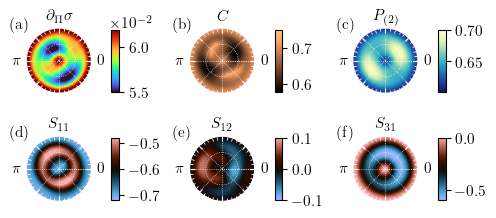

In [55]:
# Figure
cm = 1 / 2.54
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(0.9*20*cm, 15*cm), constrained_layout=True)
fig.set_size_inches(12/2.45, 5.3/2.45)

# Plot data
im00 = ax[0,0].pcolormesh(phi, theta, np.transpose(dW), shading='auto', cmap = cmr.get_sub_cmap('turbo', 0, 1),
                          vmin = 0.055, vmax = 0.062)
im01 = ax[0,1].pcolormesh(phi, theta, np.transpose(C), shading='auto', cmap = cmr.get_sub_cmap('copper', 0, 1),
                          vmin = 0.58, vmax = 0.75)
im02 = ax[0,2].pcolormesh(phi, theta, np.transpose(POL), shading='auto', cmap = cmr.get_sub_cmap('YlGnBu_r', 0, 1),
                          vmin = 0.6025, vmax = 0.7)

im10 = ax[1,0].pcolormesh(phi, theta, np.transpose(S11), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1),
                          vmin = -0.72, vmax = -0.48)
im11 = ax[1,1].pcolormesh(phi, theta, np.transpose(S12), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1),
                          vmin = -0.1, vmax = 0.1)
im12 = ax[1,2].pcolormesh(phi, theta, np.transpose(S31), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1))#,
                          #vmin = -0.65, vmax = 0.1)

# Show colorbar
clb00 = plt.colorbar(im00, ax=ax[0,0], pad=0.1, aspect=8, fraction=0.119)
clb00.formatter.set_powerlimits((0, 0))
clb00.ax.yaxis.set_offset_position('left')                         
clb00.update_ticks()

plt.colorbar(im01, ax=ax[0,1], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im02, ax=ax[0,2], pad=0.1, aspect=8, fraction=0.119, ticks=[0.7, 0.65])

plt.colorbar(im10, ax=ax[1,0], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im11, ax=ax[1,1], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im12, ax=ax[1,2], pad=0.1, aspect=8, fraction=0.119)

for i in range(2):
    for j in range(3):
        ax[i,j].yaxis.set_visible(False)

#plt.subplots_adjust(wspace=0.5)

# Titles
ax[0,0].set_title('$\partial_{\Pi}\\sigma$', fontsize=11);
ax[0,1].set_title('$C$', fontsize=11);
ax[0,2].set_title('$P_{(2)}$', fontsize=11);

ax[1,0].set_title('$S_{11}$', fontsize=11);
ax[1,1].set_title('$S_{12}$', fontsize=11);
ax[1,2].set_title('$S_{31}$', fontsize=11);

for j in range(3):
    for spine in ax[0,j].spines.values():
        spine.set_edgecolor('white')
    for spine in ax[1,j].spines.values():
        spine.set_edgecolor('white')
        
for j in range(3):
    ax[0,j].xaxis.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi])
    ax[0,j].set_xticklabels(['$0$', '', '', '', '$\pi$', '', '', '', '']) 
    ax[0,j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax[0,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
    ax[0,j].grid(color='white', linestyle=':', linewidth=0.5)
    ax[0,j].plot(phi, np.pi/2 + np.zeros(len(phi)), color='white', linestyle=':', linewidth=0.5);
    
    ax[1,j].xaxis.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi])
    ax[1,j].set_xticklabels(['$0$', '', '', '', '$\pi$', '', '', '', '']) 
    ax[1,j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax[1,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
    ax[1,j].grid(color='white', linestyle=':', linewidth=0.5)
    ax[1,j].plot(phi, np.pi/2 + np.zeros(len(phi)), color='white', linestyle=':', linewidth=0.5);
    
    ax[0,j].set_rmin(0)
    ax[1,j].set_rmin(0)
    ax[0,j].set_rmax(np.pi)
    ax[1,j].set_rmax(np.pi)
    
# Labels
ax[0,0].annotate('(a)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[0,1].annotate('(b)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[0,2].annotate('(c)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,0].annotate('(d)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,1].annotate('(e)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,2].annotate('(f)', (-0.25, 1), xycoords='axes fraction', color='k');

# Save figure
plt.savefig('NEW_angular_annihilation_p_200keV.pdf', dpi=1000, bbox_inches='tight');
plt.show();

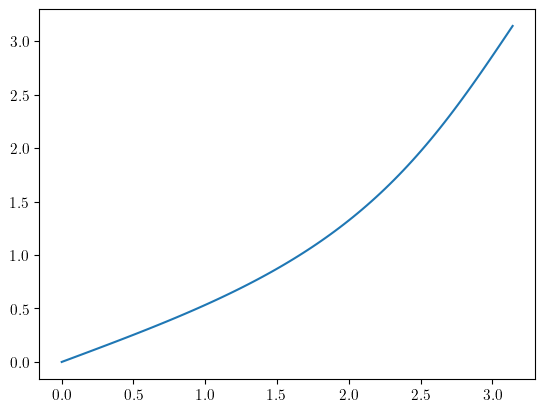

In [11]:
beta = qtl.ThreeVector(0.6, 0, 0)

theta_b = []
phi_b = []
for j in range(len(theta)):
    pmu = qtl.FourVector(energy, energy, theta[j], 0)
    pmu_b = qtl.boost(pmu, beta)
    theta_b.append(pmu_b.sphericals[2])
    
plt.plot(theta, theta_b);

In [12]:
plus_l_b = qtl.boost(plus_l, beta)
plus_r_b = qtl.boost(plus_r, beta)
plus_h_b = qtl.boost(plus_h, beta)
minus_r_b = qtl.boost(minus_r, beta)
minus_v_b = qtl.boost(minus_v, beta)

state_1_b = (plus_l_b * minus_r_b + plus_h_b * minus_v_b) / np.sqrt(2)
state_2_b = plus_r_b * minus_r_b
w = [0.4, 0.6]
states_b = [state_1_b, state_2_b]
in_state_b = qtl.QuantumState.mixed(states_b, w)
# in_state_b = state_2_b

In [13]:
# print("unboosted:")
# print(np.round(state_1.rho,4))
# print(np.round(state_2.rho,4))
# print(np.round(in_state.rho,4))
# print()
# print("boosted:")
# print(np.round(state_1_b.rho,4))
# print(np.round(state_2_b.rho,4))
# print(np.round(in_state_b.rho,4))

In [14]:
data_b = qtl.empty_lists(12)

# Needed for differential cross section
pmu_e_b = qtl.boost(pmu_e, beta)
pmu_p_b = qtl.boost(pmu_p, beta)

for a in range(len(phi)):
    
    data_a = qtl.empty_lists(12)
    
    for i in range(len(theta)):

        amplitudes = []

        for j in range(len(h)):

            amplitudes_row = []

            for k in range(len(h[j])):

                # k-loop

                kmu_1 = qtl.FourVector(energy, energy, theta[i], phi[a])
                kmu_2 = -kmu_1

                qmu_1 = pmu_e - kmu_1
                qmu_2 = pmu_e - kmu_2

                electron = qtl.RealParticle.electron(h[j][k][0], pmu_e, "in")
                positron = qtl.RealParticle.positron(h[j][k][1], pmu_p, "in")
                photon_1 = qtl.RealParticle.photon(h[j][k][2], kmu_1, "out")
                photon_2 = qtl.RealParticle.photon(h[j][k][3], kmu_2, "out")
                
                u = electron.polarization.bispinor
                v = positron.polarization.bispinor
                
                e1 = -1j * e * qtl.slashed(photon_1.polarization)
                e2 = -1j * e * qtl.slashed(photon_2.polarization)
                
                fermion_1 = qtl.VirtualParticle.electron(qmu_1)
                fermion_2 = qtl.VirtualParticle.electron(qmu_2)
                
                g1 = fermion_1.propagator
                g2 = fermion_2.propagator
                
                amplitude = v.dot(e2).dot(g1).dot(e1).dot(u) \
                            + v.dot(e1).dot(g2).dot(e2).dot(u)
                
                amplitudes_row.append(amplitude)
            
            amplitudes.append(amplitudes_row)
            
        out = qtl.QuantumState.out_state(in_state_b, amplitudes)

        dw = qtl.diff_cross_section(pmu_e_b, pmu_p_b, out)
        conc = qtl.concurrence(out)
        pol = qtl.degree_polarization(out)
        s11 = qtl.stokes_parameter(out, [1, 1])
        s12 = qtl.stokes_parameter(out, [1, 2])
        s13 = qtl.stokes_parameter(out, [1, 3])
        s21 = qtl.stokes_parameter(out, [2, 1])
        s22 = qtl.stokes_parameter(out, [2, 2])
        s23 = qtl.stokes_parameter(out, [2, 3])
        s31 = qtl.stokes_parameter(out, [3, 1])
        s32 = qtl.stokes_parameter(out, [3, 2])
        s33 = qtl.stokes_parameter(out, [3, 3])
            
        quantities = [dw, conc, pol, 
                      s11, s12, s13,
                      s21, s22, s23,
                      s31, s32, s33]
        
        for l in range(len(data_a)):
            data_a[l].append(quantities[l])
                
    for n in range(len(data_b)):
        data_b[n].append(data_a[n])


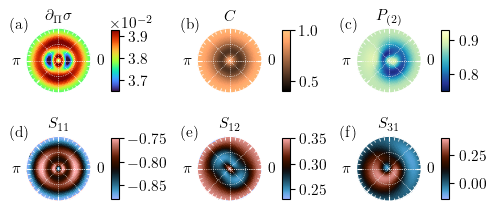

In [56]:
dW_b = data_b[0]
C_b = data_b[1]
POL_b = data_b[2]
S11_b = data_b[3]
S12_b = data_b[4]
S31_b = data_b[9]

# Figure
cm = 1 / 2.54
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(0.9*20*cm, 15*cm), constrained_layout=True)
fig.set_size_inches(12/2.45, 5.3/2.45)

# Plot data
im00 = ax[0,0].pcolormesh(phi, theta_b, np.transpose(dW_b), shading='auto', cmap = cmr.get_sub_cmap('turbo', 0, 1),
                          vmin = 0.0365, vmax=0.0393)
im01 = ax[0,1].pcolormesh(phi, theta_b, np.transpose(C_b), shading='auto', cmap = cmr.get_sub_cmap('copper', 0, 1),
                          vmin = 0.4, vmax = 1)
im02 = ax[0,2].pcolormesh(phi, theta_b, np.transpose(POL_b), shading='auto', cmap = cmr.get_sub_cmap('YlGnBu_r', 0, 1),
                          vmin = 0.75, vmax = 0.93)

im10 = ax[1,0].pcolormesh(phi, theta_b, np.transpose(S11_b), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1),
                          vmin = -0.88, vmax = -0.75)
im11 = ax[1,1].pcolormesh(phi, theta_b, np.transpose(S12_b), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1),
                          vmin = 0.23, vmax = 0.35)
im12 = ax[1,2].pcolormesh(phi, theta_b, np.transpose(S31_b), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1),
                          vmin = -0.15, vmax = 0.4)

# Show colorbar
clb00 = plt.colorbar(im00, ax=ax[0,0], pad=0.1, aspect=8, fraction=0.119)
clb00.formatter.set_powerlimits((0, 0))
clb00.ax.yaxis.set_offset_position('left')                         
clb00.update_ticks()

plt.colorbar(im01, ax=ax[0,1], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im02, ax=ax[0,2], pad=0.1, aspect=8, fraction=0.119)

plt.colorbar(im10, ax=ax[1,0], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im11, ax=ax[1,1], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im12, ax=ax[1,2], pad=0.1, aspect=8, fraction=0.119)

for i in range(2):
    for j in range(3):
        ax[i,j].yaxis.set_visible(False)

#plt.subplots_adjust(wspace=0.5)

# Titles
ax[0,0].set_title('$\partial_{\Pi}\\sigma$', fontsize=11);
ax[0,1].set_title('$C$', fontsize=11);
ax[0,2].set_title('$P_{(2)}$', fontsize=11);

ax[1,0].set_title('$S_{11}$', fontsize=11);
ax[1,1].set_title('$S_{12}$', fontsize=11);
ax[1,2].set_title('$S_{31}$', fontsize=11);

for j in range(3):
    for spine in ax[0,j].spines.values():
        spine.set_edgecolor('white')
    for spine in ax[1,j].spines.values():
        spine.set_edgecolor('white')
        
for j in range(3):
    ax[0,j].xaxis.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi])
    ax[0,j].set_xticklabels(['$0$', '', '', '', '$\pi$', '', '', '', '']) 
    ax[0,j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax[0,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
    ax[0,j].grid(color='white', linestyle=':', linewidth=0.5)
    ax[0,j].plot(phi, np.pi/2 + np.zeros(len(phi)), color='white', linestyle=':', linewidth=0.5);
    
    ax[1,j].xaxis.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi])
    ax[1,j].set_xticklabels(['$0$', '', '', '', '$\pi$', '', '', '', '']) 
    ax[1,j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax[1,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
    ax[1,j].grid(color='white', linestyle=':', linewidth=0.5)
    ax[1,j].plot(phi, np.pi/2 + np.zeros(len(phi)), color='white', linestyle=':', linewidth=0.5);
    
    ax[0,j].set_rmin(theta_b[0])
    ax[1,j].set_rmin(theta_b[0])
    ax[0,j].set_rmax(theta_b[-1])
    ax[1,j].set_rmax(theta_b[-1])
    
# # Labels
# ax[0,0].annotate('$\partial_{\bar{\mathsf{p}}}W$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[0,1].annotate('$C$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[0,2].annotate('$P_{(2)}$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,0].annotate('$S_{11}$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,1].annotate('$S_{12}$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,2].annotate('$S_{31}$', (-0.25, 1), xycoords='axes fraction', color='k');

# Labels
ax[0,0].annotate('(a)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[0,1].annotate('(b)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[0,2].annotate('(c)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,0].annotate('(d)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,1].annotate('(e)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,2].annotate('(f)', (-0.25, 1), xycoords='axes fraction', color='k');

# Save figure
plt.savefig('NEW_angular_annihilation_p_200keV_boosted.pdf', dpi=1000, bbox_inches='tight');
plt.show();

In [16]:
data_b2 = qtl.empty_lists(12)

for a in range(len(phi)):
    
    data_a = qtl.empty_lists(12)
    
    for i in range(len(theta)):

        amplitudes = []

        for j in range(len(h)):

            amplitudes_row = []

            for k in range(len(h[j])):

                # k-loop

                kmu_1 = qtl.FourVector(energy, energy, theta[i], phi[a])
                kmu_2 = -kmu_1

                electron = qtl.boost(qtl.RealParticle.electron(h[j][k][0], pmu_e, "in"), beta)
                positron = qtl.boost(qtl.RealParticle.positron(h[j][k][1], pmu_p, "in"), beta)
                photon_1 = qtl.boost(qtl.RealParticle.photon(h[j][k][2], kmu_1, "out"), beta)
                photon_2 = qtl.boost(qtl.RealParticle.photon(h[j][k][3], kmu_2, "out"), beta)
                
                qmu_1 = pmu_e_b - photon_1.pmu
                qmu_2 = pmu_e_b - photon_2.pmu
                
                u = electron.polarization.bispinor
                v = positron.polarization.bispinor
                
                e1 = -1j * e * qtl.slashed(photon_1.polarization)
                e2 = -1j * e * qtl.slashed(photon_2.polarization)
                
                fermion_1 = qtl.boost(qtl.VirtualParticle.electron(qmu_1), beta)
                fermion_2 = qtl.boost(qtl.VirtualParticle.electron(qmu_2), beta)
                
                g1 = fermion_1.propagator
                g2 = fermion_2.propagator
                
                amplitude = v.dot(e2).dot(g1).dot(e1).dot(u) \
                            + v.dot(e1).dot(g2).dot(e2).dot(u)
                
                amplitudes_row.append(amplitude)
            
            amplitudes.append(amplitudes_row)
            
        out = qtl.QuantumState.out_state(in_state_b, amplitudes)

        dw = qtl.diff_cross_section(pmu_e, pmu_p, out)
        conc = qtl.concurrence(out)
        pol = qtl.degree_polarization(out)
        s11 = qtl.stokes_parameter(out, [1, 1])
        s12 = qtl.stokes_parameter(out, [1, 2])
        s13 = qtl.stokes_parameter(out, [1, 3])
        s21 = qtl.stokes_parameter(out, [2, 1])
        s22 = qtl.stokes_parameter(out, [2, 2])
        s23 = qtl.stokes_parameter(out, [2, 3])
        s31 = qtl.stokes_parameter(out, [3, 1])
        s32 = qtl.stokes_parameter(out, [3, 2])
        s33 = qtl.stokes_parameter(out, [3, 3])
            
        quantities = [dw, conc, pol, 
                      s11, s12, s13,
                      s21, s22, s23,
                      s31, s32, s33]
        
        for l in range(len(data_a)):
            data_a[l].append(quantities[l])
                
    for n in range(len(data_b)):
        data_b2[n].append(data_a[n])


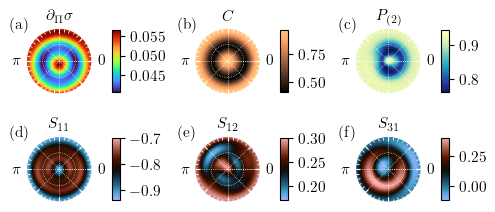

In [39]:
dW_b2 = data_b2[0]
C_b2 = data_b2[1]
POL_b2 = data_b2[2]
S11_b2 = data_b2[3]
S12_b2 = data_b2[4]
S31_b2 = data_b2[9]

# Figure
cm = 1 / 2.54
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(0.9*20*cm, 15*cm), constrained_layout=True)
fig.set_size_inches(12/2.45, 5.3/2.45)

# Plot data
im00 = ax[0,0].pcolormesh(phi, theta, np.transpose(dW_b2), shading='auto', cmap = cmr.get_sub_cmap('turbo', 0, 1))
im01 = ax[0,1].pcolormesh(phi, theta, np.transpose(C_b2), shading='auto', cmap = cmr.get_sub_cmap('copper', 0, 1))#,
                          #vmin = 0, vmax = 1)
im02 = ax[0,2].pcolormesh(phi, theta_b, np.transpose(POL_b2), shading='auto', cmap = cmr.get_sub_cmap('YlGnBu_r', 0, 1),
                          vmin = 0.76, vmax = 0.945)

im10 = ax[1,0].pcolormesh(phi, theta, np.transpose(S11_b2), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1),
                          vmin = -0.94, vmax = -0.7)
im11 = ax[1,1].pcolormesh(phi, theta, np.transpose(S12_b2), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1),
                          vmin = 0.17, vmax = 0.3)
im12 = ax[1,2].pcolormesh(phi, theta, np.transpose(S31_b2), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1))#,
                          #vmin = -1, vmax = 1)

# Show colorbar
plt.colorbar(im00, ax=ax[0,0], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im01, ax=ax[0,1], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im02, ax=ax[0,2], pad=0.1, aspect=8, fraction=0.119)

plt.colorbar(im10, ax=ax[1,0], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im11, ax=ax[1,1], pad=0.1, aspect=8, fraction=0.119)
plt.colorbar(im12, ax=ax[1,2], pad=0.1, aspect=8, fraction=0.119)

for i in range(2):
    for j in range(3):
        ax[i,j].yaxis.set_visible(False)

#plt.subplots_adjust(wspace=0.5)

# Titles
ax[0,0].set_title('$\partial_{\Pi}\\sigma$', fontsize=11);
ax[0,1].set_title('$C$', fontsize=11);
ax[0,2].set_title('$P_{(2)}$', fontsize=11);

ax[1,0].set_title('$S_{11}$', fontsize=11);
ax[1,1].set_title('$S_{12}$', fontsize=11);
ax[1,2].set_title('$S_{31}$', fontsize=11);

for j in range(3):
    for spine in ax[0,j].spines.values():
        spine.set_edgecolor('white')
    for spine in ax[1,j].spines.values():
        spine.set_edgecolor('white')
        
for j in range(3):
    ax[0,j].xaxis.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi])
    ax[0,j].set_xticklabels(['$0$', '', '', '', '$\pi$', '', '', '', '']) 
    ax[0,j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax[0,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
    ax[0,j].grid(color='white', linestyle=':', linewidth=0.5)
    ax[0,j].plot(phi, np.pi/2 + np.zeros(len(phi)), color='white', linestyle=':', linewidth=0.5);
    
    ax[1,j].xaxis.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi])
    ax[1,j].set_xticklabels(['$0$', '', '', '', '$\pi$', '', '', '', '']) 
    ax[1,j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
    ax[1,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
    ax[1,j].grid(color='white', linestyle=':', linewidth=0.5)
    ax[1,j].plot(phi, np.pi/2 + np.zeros(len(phi)), color='white', linestyle=':', linewidth=0.5);
    
    ax[0,j].set_rmin(theta_b[0])
    ax[1,j].set_rmin(theta_b[0])
    ax[0,j].set_rmax(theta_b[-1])
    ax[1,j].set_rmax(theta_b[-1])
    
# # Labels
# ax[0,0].annotate('$\partial_{\bar{\mathsf{p}}}W$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[0,1].annotate('$C$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[0,2].annotate('$P_{(2)}$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,0].annotate('$S_{11}$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,1].annotate('$S_{12}$', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,2].annotate('$S_{31}$', (-0.25, 1), xycoords='axes fraction', color='k');

# Labels
ax[0,0].annotate('(a)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[0,1].annotate('(b)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[0,2].annotate('(c)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,0].annotate('(d)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,1].annotate('(e)', (-0.25, 1), xycoords='axes fraction', color='k');
ax[1,2].annotate('(f)', (-0.25, 1), xycoords='axes fraction', color='k');

# # Save figure
# plt.savefig('NEW_angular_annihilation_p_200keV_boosted.pdf', dpi=1000, bbox_inches='tight');
# plt.show();

In [18]:
# # Figure
# cm = 1 / 2.54
# fig, ax = plt.subplots(2, 3, subplot_kw={'projection': 'polar'}, figsize=(0.9*19*cm, 14*cm), constrained_layout=True)
# fig.set_size_inches(12/2.45, 5.3/2.45)

# # Plot data
# im00 = ax[0,0].pcolormesh(phi, theta, np.transpose(dW_b), shading='auto', cmap = cmr.get_sub_cmap('turbo', 0, 1))
# im01 = ax[0,1].pcolormesh(phi, theta, np.transpose(C_b), shading='auto', cmap = cmr.get_sub_cmap('copper', 0, 1))#,
#                           #vmin = 0, vmax = 1)
# im02 = ax[0,2].pcolormesh(phi, theta, np.transpose(POL_b), shading='auto', cmap = cmr.get_sub_cmap('YlGnBu_r', 0, 1))#,
#                           #vmin = 0, vmax = 1)

# im10 = ax[1,0].pcolormesh(phi, theta, np.transpose(S11_b), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1))#,
#                           #vmin = -1, vmax = 1)
# im11 = ax[1,1].pcolormesh(phi, theta, np.transpose(S12_b), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1))#,
#                           #vmin = -1, vmax = 1)
# im12 = ax[1,2].pcolormesh(phi, theta, np.transpose(S31_b), shading='auto', cmap = cmr.get_sub_cmap('berlin', 0, 1))#,
#                           #vmin = -1, vmax = 1)

# # Show colorbar
# plt.colorbar(im00, ax=ax[0,0], pad=0.1, aspect=8, fraction=0.119)
# plt.colorbar(im01, ax=ax[0,1], pad=0.1, aspect=8, fraction=0.119)
# plt.colorbar(im02, ax=ax[0,2], pad=0.1, aspect=8, fraction=0.119)

# plt.colorbar(im10, ax=ax[1,0], pad=0.1, aspect=8, fraction=0.119)
# plt.colorbar(im11, ax=ax[1,1], pad=0.1, aspect=8, fraction=0.119)
# plt.colorbar(im12, ax=ax[1,2], pad=0.1, aspect=8, fraction=0.119)

# for i in range(2):
#     for j in range(3):
#         ax[i,j].yaxis.set_visible(False)

# #plt.subplots_adjust(wspace=0.5)

# # Titles
# ax[0,0].set_title('$\partial_{\Pi}\\sigma$', fontsize=11);
# ax[0,1].set_title('$C$', fontsize=11);
# ax[0,2].set_title('$P_{(2)}$', fontsize=11);

# ax[1,0].set_title('$S_{11}$', fontsize=11);
# ax[1,1].set_title('$S_{12}$', fontsize=11);
# ax[1,2].set_title('$S_{31}$', fontsize=11);

# for j in range(3):
#     for spine in ax[0,j].spines.values():
#         spine.set_edgecolor('white')
#     for spine in ax[1,j].spines.values():
#         spine.set_edgecolor('white')
        
# for j in range(3):
#     ax[0,j].xaxis.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi])
#     ax[0,j].set_xticklabels(['$0$', '', '', '', '$\pi$', '', '', '', '']) 
#     ax[0,j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
#     ax[0,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
#     ax[0,j].grid(color='white', linestyle=':', linewidth=0.5)
#     ax[0,j].plot(phi, np.pi/2 + np.zeros(len(phi)), color='white', linestyle=':', linewidth=0.5);
    
#     ax[1,j].xaxis.set_ticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, np.pi + np.pi/4, np.pi + np.pi/2, np.pi + 3*np.pi/4, 2*np.pi])
#     ax[1,j].set_xticklabels(['$0$', '', '', '', '$\pi$', '', '', '', '']) 
#     ax[1,j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
#     ax[1,j].tick_params(axis='both', which='both', direction='in', right=True, top=True, color='white', pad=0.05)
#     ax[1,j].grid(color='white', linestyle=':', linewidth=0.5)
#     ax[1,j].plot(phi, np.pi/2 + np.zeros(len(phi)), color='white', linestyle=':', linewidth=0.5);
    
#     ax[0,j].set_rmin(0)
#     ax[1,j].set_rmin(0)
#     ax[0,j].set_rmax(np.pi)
#     ax[1,j].set_rmax(np.pi)
    
# # # Labels
# # ax[0,0].annotate('$\partial_{\bar{\mathsf{p}}}W$', (-0.25, 1), xycoords='axes fraction', color='k');
# # ax[0,1].annotate('$C$', (-0.25, 1), xycoords='axes fraction', color='k');
# # ax[0,2].annotate('$P_{(2)}$', (-0.25, 1), xycoords='axes fraction', color='k');
# # ax[1,0].annotate('$S_{11}$', (-0.25, 1), xycoords='axes fraction', color='k');
# # ax[1,1].annotate('$S_{12}$', (-0.25, 1), xycoords='axes fraction', color='k');
# # ax[1,2].annotate('$S_{31}$', (-0.25, 1), xycoords='axes fraction', color='k');

# # Labels
# ax[0,0].annotate('(a)', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[0,1].annotate('(b)', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[0,2].annotate('(c)', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,0].annotate('(d)', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,1].annotate('(e)', (-0.25, 1), xycoords='axes fraction', color='k');
# ax[1,2].annotate('(f)', (-0.25, 1), xycoords='axes fraction', color='k');

# # # Save figure
# # plt.savefig('NEW_angular_annihilation_p_900keV_boosted_old-coordinates.pdf', dpi=1000, bbox_inches='tight');
# # plt.show();

In [19]:
zmu = qtl.FourVector(1,1,0,0)
beta_q = qtl.ThreeVector(0.9,np.pi/2,0)

left_z = qtl.QuantumState.single(zmu, "L")
left_zb = qtl.boost(left_z, beta_q)

print(left_zb.ket)

[1.-1.49011612e-08j 0.+0.00000000e+00j]
